# Lab 3-2: Snow Density and Compaction

For this example, we want to combine the snow depth and snow water equivalent data to investigate changes in snow density with time.


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data file (we will focus on lidar 6, others will be useful for the homework)
ds6 = xr.open_dataset('../data/lidar_l6_pillow_depths.nc')
# you may need to check the path here -- 
# if you put the dataset in the same folder as this lab, erase the ../data/ part above 

# Also make the accompanying timeseries info
start_date = dt.datetime(2022, 10, 10)
end_date = dt.datetime(2023, 3, 25)

ds6

<xarray.Dataset>
Dimensions:    (time: 149, stat: 6, pillow: 3)
Coordinates:
  * time       (time) datetime64[ns] 2022-10-14 2022-10-15 ... 2023-03-21
  * stat       (stat) object 'mean' 'stddev' 'median' 'min' 'max' 'count'
  * pillow     (pillow) object 'C' 'UW' 'D'
Data variables:
    snowdepth  (time, stat, pillow) float64 ...

Now load the SWE dataset from Module 2.

In [4]:
sos_dataset_60min=xr.open_dataset("../data/sos_SWE_T_P.nc")
# you may need to check the path here -- 
# if you put the dataset in the same folder as this lab, erase the ../data/ part above 

# Provide a the start and end dates you want to download
start_dateSWE = '20221201'
end_dateSWE = '20230327'

# Provide the specific variables you want to extract from the dataset.
# We provide these in advance because the datasets are very large and, 
# when we open them, we want to immediately extract only the data we want.
VARIABLES = [
    'SWE_p1_c',
    'SWE_p2_c',
    'SWE_p3_c',
    'SWE_p4_c',
    'T_2m_c',
]

# Note, pillow 1 is UW, pillow 2 is c, pillow 3 is UE, and pillow 4 is D.

# Create a list of datetime objects for every day between the provided start_date and end_date. 
datelist = pd.date_range(
    dt.datetime.strptime(start_dateSWE, '%Y%m%d'),
    dt.datetime.strptime(end_dateSWE, '%Y%m%d'),
    freq='d'
).strftime('%Y%m%d').tolist()

For the central snow pillow, make a plot of both depth and SWE.

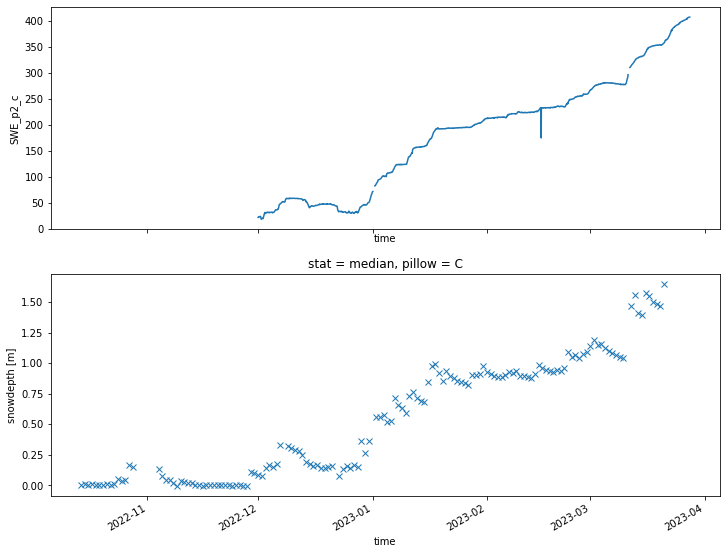

In [5]:
# We'll do this here for the central pillow location; you will want to repeat for the others
s="median"
fig, axes = plt.subplots(2, 1, figsize=(12,9), sharex=True)
sos_dataset_60min['SWE_p2_c'].plot(ax=axes[0], label='SWE_p2_c')
ds6["snowdepth"].sel(stat=s,pillow="C").plot(ax=axes[1],marker='x', linestyle="", label="c")

In order to calculate the density, which, in bulk, is SWE/depth, we need the data to be sampled at matching timesteps.  We can do that by interpolating the hourly SWE timeseries to the time stamps of the daily depth timeseries.

In [6]:
sos_dataset_60min_interpolated = sos_dataset_60min.interp_like(ds6)
density_uw = sos_dataset_60min_interpolated['SWE_p1_c'] / ds6.sel(pillow='UW', stat='median')['snowdepth']
density_c = sos_dataset_60min_interpolated['SWE_p3_c'] / ds6.sel(pillow='C', stat='median')['snowdepth']
density_d = sos_dataset_60min_interpolated['SWE_p4_c'] / ds6.sel(pillow='D', stat='median')['snowdepth']

Ah, except there's something really terrible about the code above.  Think about the units we want for density.  Personally, I like to think in fractional water content, and I have some benchmarks from reading and experience.
* New snow has a density of about 10% or 0.1
* Typical bulk density of an arctic or Colorado snowpack is 30% or 0.3
* Typical density of a ripe snowpack (with higher water content, about ready to melt) is 40% or 0.4
* A very wet snowpack with water or ice layers in it is 50% or 0.5
* The densest snowpack I ever saw was when heavy rain fell on subfreezing deep snow in the Sierra, and about half a meter became ice; density was 70%

No handles with labels found to put in legend.


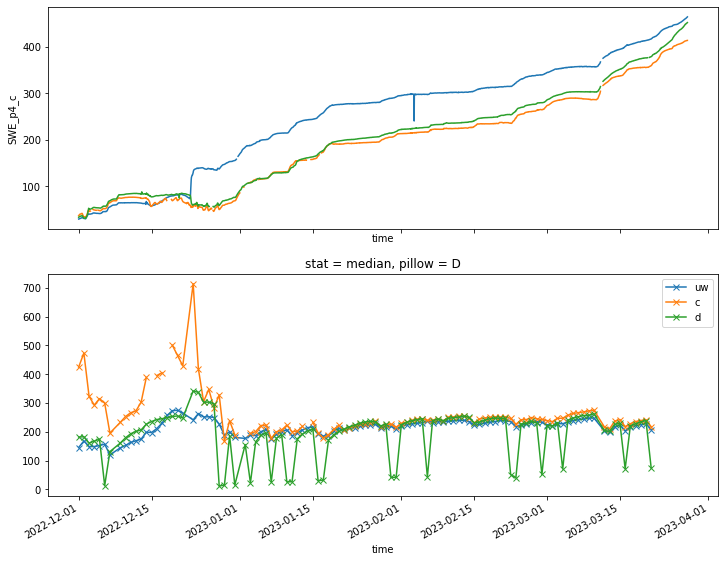

In [12]:
#with that in mind, let's plot our densities below a SWE timeseries
fig, axes = plt.subplots(2, 1, figsize=(12,9), sharex=True)
sos_dataset_60min['SWE_p1_c'].plot(ax=axes[0], label='SWE_p1_c')
sos_dataset_60min['SWE_p3_c'].plot(ax=axes[0], label='SWE_p3_c')
sos_dataset_60min['SWE_p4_c'].plot(ax=axes[0], label='SWE_p4_c')
plt.legend()
density_uw.plot(ax=axes[1],marker='x', linestyle="-", label="uw")
density_c.plot(ax=axes[1],marker='x', linestyle="-", label="c")
density_d.plot(ax=axes[1],marker='x', linestyle="-", label="d")
plt.legend()

What units should go on the above graph for density?  It should not be fraction, or percent, but g per m^3 would work.
What do you think is happening at the center snow pillowin late December?

You will examine these data further in homework 4.  For now, let's consider the potential role of compaction.  
![image from Essery paper](../data/Essery_simple_compaction.png)

The simplest approach, as described in [Essery et al 2013](https://www.sciencedirect.com/science/article/pii/S0309170812002011) and pictured above, is to assume that snow compacts from its original density to some defined maximum density following an exponential decay. 

In [15]:
from math import exp

ro_max = 300 #kg/m^3
tau_p = 3.6e5 #s
ro_s = [200] #kg/m^3

for t in range(0, 5*24*3600): #seconds for five days
    ro_s.append(ro_max + (ro_s[t] - ro_max)*exp(-1/tau_p))


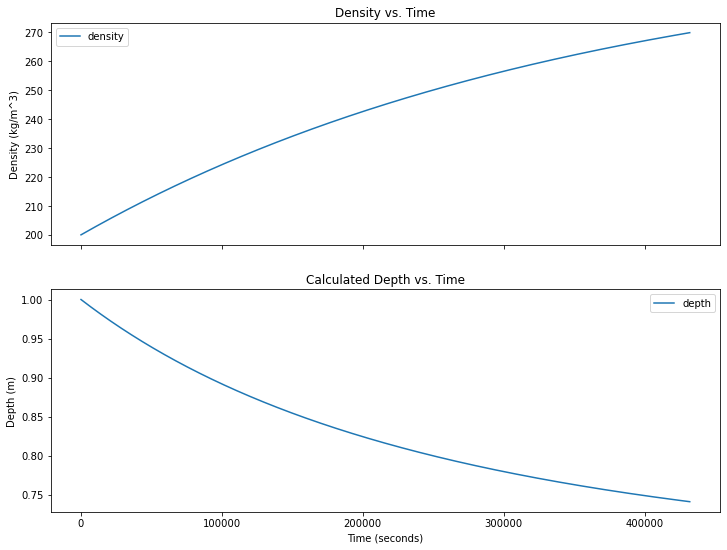

In [18]:
#Now make a theoretical plot of both density and depth
# first calculate depth
# Assume SWE is 0.2 meters
d_calc = [0.2*1000/ro for ro in ro_s]


# create the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(12,9), sharex=True)

# plot the density data
axes[0].plot(ro_s, label='density')

# set the title and labels for the first subplot
axes[0].set_title('Density vs. Time')
axes[0].set_ylabel('Density (kg/m^3)')

# plot the calculated depth data
axes[1].plot(d_calc, label='depth')

# set the title and labels for the second subplot
axes[1].set_title('Calculated Depth vs. Time')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Depth (m)')

# add a legend to each subplot
axes[0].legend()
axes[1].legend()

# display the plot
plt.show()


Now, on your own, determine whether our observations agree with this empirical calcuation.